# Image Classification with DNN

## DATASETS:
(a) Carbonic Anhydrase II (ChEMBL205), a protein lyase,  
(b) Cyclin-dependent kinase 2 (CHEMBL301), a protein kinase,  
(c) ether-a-go-go-related gene potassium channel 1 (HERG) (CHEMBL240), a voltage-gated ion channel,  
(d) Dopamine D4 receptor (CHEMBL219), a monoamine GPCR,  
(e) Coagulation factor X (CHEMBL244), a serine protease,  
(f) Cannabinoid CB1 receptor (CHEMBL218), a lipid-like GPCR and  
(g) Cytochrome P450 19A1 (CHEMBL1978), a cytochrome P450.  
The activity classes were selected based on data availability and as representatives of therapeutically important target classes or as anti-targets.

In [1]:
top_mcc_scores = {
    
    'CHEMBL205': 0.862,
    'CHEMBL301': 0.926,
    'CHEMBL240': 0.884,
    'CHEMBL219': 0.887,
    'CHEMBL244': 0.983,
    'CHEMBL218': 0.941,
    'CHEMBL1978': 0.904}

In [2]:
!nvidia-smi

Tue Oct  5 15:03:11 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.91.03    Driver Version: 460.91.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 1080    Off  | 00000000:01:00.0  On |                  N/A |
|  0%   51C    P8    18W / 240W |   1463MiB /  8116MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# Import
import pandas as pd
import numpy as np
from pathlib import Path

In [4]:
dataset='CHEMBL205_cl'

In [5]:
path = Path('../dataset/13321_2017_226_MOESM1_ESM/')
#df = pd.read_csv(path/f'{dataset}.csv')

In [6]:
list(path.iterdir())

[PosixPath('../dataset/13321_2017_226_MOESM1_ESM/CHEMBL1978_cl_ecfp_1024.csv'),
 PosixPath('../dataset/13321_2017_226_MOESM1_ESM/CHEMBL244_cl_ecfp_512.csv'),
 PosixPath('../dataset/13321_2017_226_MOESM1_ESM/CHEMBL218_cl.csv'),
 PosixPath('../dataset/13321_2017_226_MOESM1_ESM/RdkitDescriptors.py'),
 PosixPath('../dataset/13321_2017_226_MOESM1_ESM/CHEMBL205_cl_ecfp_512.csv'),
 PosixPath('../dataset/13321_2017_226_MOESM1_ESM/CHEMBL301_cl.csv'),
 PosixPath('../dataset/13321_2017_226_MOESM1_ESM/CHEMBL205_cl_ecfp_1024.csv'),
 PosixPath('../dataset/13321_2017_226_MOESM1_ESM/CHEMBL1978_cl_ecfp_512.csv'),
 PosixPath('../dataset/13321_2017_226_MOESM1_ESM/CHEMBL240_cl.csv'),
 PosixPath('../dataset/13321_2017_226_MOESM1_ESM/CHEMBL301_cl_ecfp_512.csv'),
 PosixPath('../dataset/13321_2017_226_MOESM1_ESM/CHEMBL218_cl_ecfp_1024.csv'),
 PosixPath('../dataset/13321_2017_226_MOESM1_ESM/CHEMBL301_cl_ecfp_1024.csv'),
 PosixPath('../dataset/13321_2017_226_MOESM1_ESM/CHEMBL205_cl.csv'),
 PosixPath('../dataset

# Generate activations

In [21]:
DATA = path/'mol_images'

# Create train validation split

In [8]:
from sklearn.model_selection import train_test_split

In [15]:
def get_df(data):
    """
    Construct a dataframe containing 
        CID, SMILES, Image, Activity
    """
    
    df = pd.read_csv(path/f'{dataset}.csv')
    df['Image'] = df['CID'].apply(lambda x: f'{str(x)}.png')
    
    df = df[['CID', 'SMILES', 'Image', 'Activity']]
    
    return df

In [16]:
df = get_df(dataset)

# Create dataloader

In [17]:
from fastai.vision.all import *

In [18]:
# No flips, some rotation and zoom. Normalize to imagenet_stats as
# we're using pretrained models.
batch_tfms = [*aug_transforms(mult=1.0, do_flip=False, flip_vert=False, 
               max_rotate=20.0, min_zoom=1.0, max_zoom=1.1, max_lighting=0., 
               max_warp=0., p_affine=0.75, p_lighting=0.75, xtra_tfms=None, 
               size=224, mode='bilinear', 
               pad_mode='border', align_corners=True, 
               batch=False, min_scale=1.0), 
              Normalize.from_stats(*imagenet_stats)]

In [19]:
def get_dls(dataset, df, random_state=42, test_size=0.2, bs=64):
    IMAGES = DATA/dataset
    x_train, x_valid = train_test_split(df.index, test_size=0.2, random_state=random_state, stratify=df['Activity'])
    df.loc[x_train, 'is_valid']=False
    df.loc[x_valid, 'is_valid']=True
    df['Image'] = df['CID'] + '.png'
    images = df['CID'] + ".png"
    db = DataBlock(
        blocks = (ImageBlock(), CategoryBlock()), 
        get_x=ColReader('Image', pref=IMAGES),
        get_y=ColReader('Activity'), 
        splitter=ColSplitter('is_valid'),
        item_tfms=None, 
        batch_tfms=batch_tfms,
        )
    dls = db.dataloaders(df, bs=bs, shuffle_train=True)
    return dls

In [22]:
dls = get_dls(dataset, df, random_state=42)

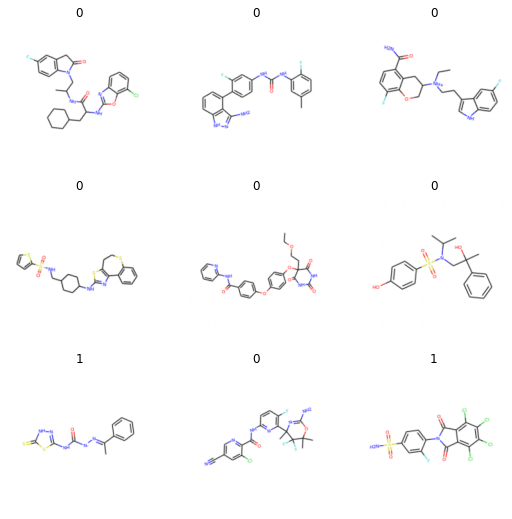

In [23]:
dls.show_batch()

In [24]:
def get_loss_func(df):
    TARGET = 'Activity'
    class_count_df = df.groupby(TARGET).count()
    n_0, n_1 = class_count_df.iloc[0, 0], class_count_df.iloc[1, 0]
    w_0 = (n_0 + n_1) / (2.0 * n_0)
    w_1 = (n_0 + n_1) / (2.0 * n_1)
    class_weights=torch.FloatTensor([w_0, w_1]).cuda()
    loss_func = CrossEntropyLossFlat(weight=class_weights)
    return loss_func

In [26]:
loss_func = get_loss_func(df)

# Train CNN model

In [31]:
from sklearn.metrics import auc,roc_auc_score,recall_score,precision_score,f1_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import accuracy_score

In [28]:
def train_model(dls, arch=resnet18, loss_func=loss_func, epochs=10, wd=None, lr=None):
    
    print(f'Training model on dataset: {dataset}')
    print(f'Architechture: {arch}')
    #print(f'Untrained epochs: freeze_epochs={freeze_epochs}')
    print(f'Trained epochs: epochs={epochs}')
    print(f'Weight decay: wd={wd}')
    learn = cnn_learner(dls, arch=arch, pretrained=True, 
                            wd=wd,
                            loss_func=loss_func,
                            metrics=[accuracy, 
                            F1Score(), 
                            Precision(), 
                            Recall(), 
                            RocAucBinary(), 
                            MatthewsCorrCoef()])
    
    if lr == None: 
        print(f'Finding learning rate...')
        lr_min, lr_steep = learn.lr_find(suggestions=True, show_plot=False)
        print(f'Training model with learning rate: {lr_min}')
        lr = lr_min
    else: 
        print(f'Training model with learning rate: {lr}')
    learn.fine_tune(epochs, lr)
    
    return learn

In [29]:
# Train model on resnet18
learn = train_model(dls, epochs=30, lr=3e-3, wd=0.002)

Training model on dataset: CHEMBL205_cl
Architechture: <function resnet18 at 0x7f72303e2730>
Trained epochs: epochs=30
Weight decay: wd=0.002
Training model with learning rate: 0.003


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.515321,0.492889,0.796601,0.449472,0.298000,0.914110,0.928735,0.448033,00:33


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.265674,0.198814,0.938980,0.731946,0.608961,0.917178,0.976185,0.717783,00:41
1,0.226224,0.220844,0.929228,0.707373,0.566421,0.941718,0.978287,0.697991,00:40
2,0.196026,0.218889,0.929228,0.706697,0.566667,0.938650,0.976376,0.696834,00:41
3,0.190486,0.140745,0.951797,0.775616,0.671910,0.917178,0.981499,0.760727,00:40
4,0.193850,0.175725,0.939537,0.739496,0.607495,0.944785,0.982706,0.729206,00:40
5,0.180706,0.223515,0.928671,0.711061,0.562500,0.966258,0.980076,0.705726,00:41
6,0.172878,0.140971,0.957370,0.800000,0.697039,0.938650,0.978672,0.787505,00:41
7,0.158636,0.150796,0.956255,0.796368,0.689888,0.941718,0.982293,0.784262,00:41
8,0.159637,0.098262,0.966286,0.819672,0.797101,0.843558,0.976048,0.801484,00:41
9,0.162417,0.196130,0.923377,0.692049,0.544974,0.947853,0.979384,0.684527,00:41


In [30]:
interp = ClassificationInterpretation.from_learner(learn)

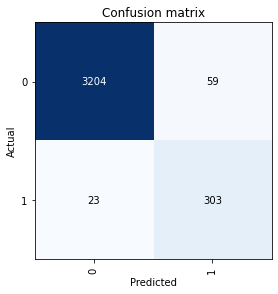

In [31]:
interp.plot_confusion_matrix()

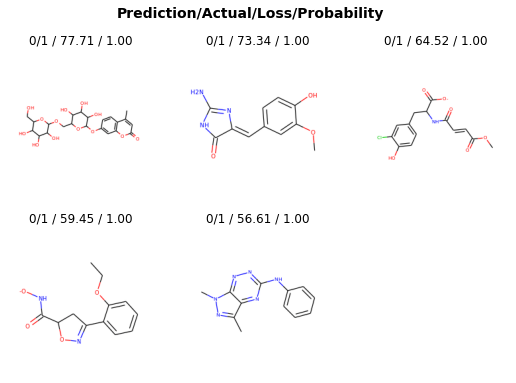

In [32]:
interp.plot_top_losses(k=5)

# Hook the activations from the second last layer

In [33]:
class Hook():
    def hook_func(self, m, i, o): self.stored = o.detach().clone()

In [34]:
learn.model[-1][-5]

Linear(in_features=1024, out_features=512, bias=False)

In [35]:
hook_output = Hook()
hook = learn.model[-1][-5].register_forward_hook(hook_output.hook_func)

In [36]:
df_nodupl=df

In [37]:
test_db = DataBlock(
    blocks=(ImageBlock(), CategoryBlock()),
    get_x=ColReader('Image', pref=IMAGES),
    get_y=ColReader('Activity'),
    splitter=RandomSplitter(valid_pct=0.),
    item_tfms=None,
    batch_tfms=None
    )

In [38]:
test_dls = test_db.dataloaders(df_nodupl, bs=1)

In [39]:
test_dls.items.head()

,CID,SMILES,Image,Activity,is_valid
4554,CHEMBL1258671,Fc1cc(c2OCCOc2c1N)C(OCC1CC[NH+](CC1)CCCC)=O,CHEMBL1258671.png,0,True
6090,CHEMBL120127,Fc1cc(F)ccc1Nc1ccc(cc1)C(=O)c1ccccc1OC,CHEMBL120127.png,0,False
16435,CHEMBL34062,Clc1cc(Cl)ccc1-c1nc(nc(N)c1C[NH3+])-c1cc(OC)cc(OC)c1,CHEMBL34062.png,0,False
11657,CHEMBL411718,Fc1cc2c(N(CC23CCN(CC3)C(=O)C)c2ncnc3[nH]ccc23)cc1,CHEMBL411718.png,0,True
2466,CHEMBL1161226,P(OCC1OC(N2C=C(F)C(=NC2=O)NO)CC1O)(=O)([O-])[O-],CHEMBL1161226.png,0,False


In [40]:
test_dls.dataset[0]

(PILImage mode=RGB size=224x224, TensorCategory(0))

In [41]:
test_df = test_dls.items.reset_index()

In [42]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17941 entries, 0 to 17940
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   index     17941 non-null  int64 
 1   CID       17941 non-null  object
 2   SMILES    17941 non-null  object
 3   Image     17941 non-null  object
 4   Activity  17941 non-null  int64 
 5   is_valid  17941 non-null  object
dtypes: int64(2), object(4)
memory usage: 841.1+ KB


In [43]:
df_nodupl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17941 entries, 0 to 17940
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   CID       17941 non-null  object
 1   SMILES    17941 non-null  object
 2   Image     17941 non-null  object
 3   Activity  17941 non-null  int64 
 4   is_valid  17941 non-null  object
dtypes: int64(1), object(4)
memory usage: 700.9+ KB


# Check

In [44]:
test_df.loc[test_df.CID == 'CHEMBL1089637']

,index,CID,SMILES,Image,Activity,is_valid
9840,1403,CHEMBL1089637,S(=O)(=O)(N)c1ccc(NC2OCC(O)C(O)C2O)cc1,CHEMBL1089637.png,1,False


In [45]:
df_nodupl.loc[df_nodupl.CID == 'CHEMBL1089637']

,CID,SMILES,Image,Activity,is_valid
1403,CHEMBL1089637,S(=O)(=O)(N)c1ccc(NC2OCC(O)C(O)C2O)cc1,CHEMBL1089637.png,1,False


In [46]:
test_dls.dataset

(#17941) [(PILImage mode=RGB size=224x224, TensorCategory(0)),(PILImage mode=RGB size=224x224, TensorCategory(0)),(PILImage mode=RGB size=224x224, TensorCategory(0)),(PILImage mode=RGB size=224x224, TensorCategory(0)),(PILImage mode=RGB size=224x224, TensorCategory(0)),(PILImage mode=RGB size=224x224, TensorCategory(0)),(PILImage mode=RGB size=224x224, TensorCategory(0)),(PILImage mode=RGB size=224x224, TensorCategory(0)),(PILImage mode=RGB size=224x224, TensorCategory(0)),(PILImage mode=RGB size=224x224, TensorCategory(0))...]

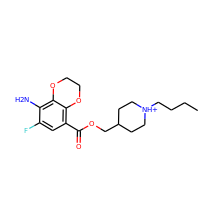

In [47]:
test_dls.dataset[0][0]

In [48]:
test_df.loc[test_df.CID=='CHEMBL1089637']

,index,CID,SMILES,Image,Activity,is_valid
9840,1403,CHEMBL1089637,S(=O)(=O)(N)c1ccc(NC2OCC(O)C(O)C2O)cc1,CHEMBL1089637.png,1,False


In [49]:
def get_data(CID):
    idx = test_df.loc[test_df.CID==CID].index[0]
    print(idx)
    return test_dls.dataset[idx]

In [50]:
t_img, t_cat = get_data('CHEMBL1089637')

9840


In [51]:
len(test_dls.dataset)

17941

In [52]:
test_dls.dataset[0]

(PILImage mode=RGB size=224x224, TensorCategory(0))

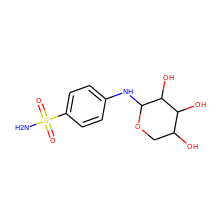

In [53]:
t_img

In [54]:
df_nodupl['activations'] = None

In [55]:
def get_activations(CID, ret=False):
    idx = df_nodupl.loc[df_nodupl.CID == CID].index[0]
    print(idx)
    data = get_data(CID)
    img = data[0]
    with torch.no_grad(): 
        output = learn.predict(img)
    acts = np.array(hook_output.stored.cpu())[0]
    #df_nodupl.iloc[idx]['acts'] = list(acts)
    if not ret: 
        df_nodupl.at[idx, 'activations'] = list(acts)
    if ret: 
        return list(acts)

In [56]:
df_nodupl.CID.values[0]

'CHEMBL188002'

In [57]:
%%capture
for CID in df_nodupl.CID.values:
    get_activations(CID)

In [58]:
df_nodupl.head()

,CID,SMILES,Image,Activity,is_valid,activations
0,CHEMBL188002,S(=O)(=O)(N)c1cc(N/C(/S)=N\c2cc(C(=O)[O-])c(cc2)C=2c3c(OC4=CC(=O)C=CC=24)cc(O)cc3)ccc1,CHEMBL188002.png,1,True,"[5.5032654, 10.048343, -17.31778, -14.053343, 13.984513, 4.864218, -4.7096953, 1.836919, -15.5555935, 6.2807765, 5.7451677, 0.8034812, 12.560091, -5.1671, -1.8028165, -5.6881456, -3.1621966, -8.89922, -16.253075, -7.7476587, -13.426832, 4.9690948, -7.7601714, 0.25577074, 9.635523, 12.561703, 13.205139, -1.8483839, -15.035667, -7.4885373, -7.072807, 18.87959, -6.307008, -1.296998, 17.30038, -2.2501817, -15.682232, -14.019539, -6.491146, 12.829754, 5.048673, 1.23248, -9.63915, 14.789265, 9.695179, 7.560721, -9.20873, -1.7431337, -8.2916975, -13.906799, -7.8764586, -4.8383646, -4.5161123, 15...."
1,CHEMBL364127,Clc1ccc(cc1)C(=O)NC1Cc2cc(S(=O)(=O)N)ccc2C1,CHEMBL364127.png,1,False,"[13.412004, 21.004574, -26.307978, -22.236359, 20.578459, 6.4365683, -5.299841, -8.453075, -21.468401, 10.683358, 10.043964, -4.7898626, 3.5844026, -7.1558247, -15.153251, -7.467156, -2.0861392, -11.127424, -28.78122, -15.189134, -31.221687, 15.231798, -19.508877, -7.5954494, 2.5442061, 13.130162, 21.339844, -16.230719, -32.418217, -22.592999, -13.521738, 7.4390984, -12.357201, 4.145323, 10.581945, -9.717069, -24.058784, -25.427433, -13.582835, 22.702097, 7.548565, -7.2093406, -15.496616, 8.820328, 16.459162, 1.7130489, -10.520281, 7.3964987, -10.056394, -21.24533, -9.718643, -4.8923907, -..."
2,CHEMBL1683469,S(=O)(=O)(N)c1ccc(cc1)CNS(=O)(=O)CC12CCC(CC1=O)C2(C)C,CHEMBL1683469.png,1,False,"[7.260055, 20.458094, -28.864317, -24.5189, 22.811634, 9.115006, -6.956635, -7.2079024, -22.600964, 3.7386644, 6.2413406, -0.6697803, 6.7333417, -6.1601934, -12.053221, -13.2139, 1.9089876, -11.963772, -25.752401, -14.5117855, -27.4222, 12.465033, -18.91936, -6.8257976, 4.745255, 15.958157, 21.13392, -12.881676, -31.549852, -19.583916, -13.471519, 15.807277, -15.616222, 3.1116667, 12.788715, -8.491629, -27.253677, -25.931664, -14.328401, 23.930843, 12.806551, -12.029712, -14.041521, 7.048623, 17.05812, 2.7910516, -8.270421, 9.1994915, -11.473135, -24.672031, -14.910112, -3.2941058, 4.33507..."
3,CHEMBL52564,Oc1ccccc1\C=C\C(=O)[O-],CHEMBL52564.png,1,False,"[15.713152, 15.654962, -4.6545277, -17.273909, 18.88624, 19.301352, -9.815918, -0.3967973, -7.7238584, 28.23034, 11.614911, -16.304138, -21.660004, -9.709376, 3.0579772, 0.6376445, -15.95339, 3.1082299, -12.458321, -15.387527, -9.103682, 16.572865, -3.1611018, 0.7017946, -9.661053, 9.195507, 10.943926, -8.438613, -8.46086, -6.1330967, -9.144573, -11.432229, -7.3922324, -5.3393316, -10.342282, -15.602887, -12.366268, -11.887112, -12.918312, 25.326591, -0.971171, -2.9504485, -8.905463, 1.1315564, 22.04964, -19.635885, -15.583317, -6.3223896, -4.6011195, -11.559268, -4.231245, -6.353094, 5.69..."
4,CHEMBL21427,OB(O)c1ccc(OC)cc1,CHEMBL21427.png,1,False,"[16.638702, 15.134977, -11.745832, -13.253998, 12.95108, 14.469639, -6.4251757, -13.358403, -12.694237, 21.63414, 12.593674, -14.496461, -17.145859, -3.5394368, -7.515234, -0.09313595, -12.603117, 5.2110987, -13.509979, -15.546734, -16.165321, 17.46834, -6.8711896, -3.4305093, -4.647941, 7.500122, 13.596459, -15.267646, -16.344229, -6.344523, -1.9548573, -9.5225725, -11.47632, -1.4816285, -12.584953, -12.47004, -8.739759, -9.981955, -11.7105465, 19.124863, 3.4045951, -11.0921335, -9.501782, 8.389684, 15.099842, -15.853493, -9.479639, -5.5205817, -4.8707905, -7.604986, -1.3077168, -7.28832,..."


In [59]:
df_nodupl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17941 entries, 0 to 17940
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   CID          17941 non-null  object
 1   SMILES       17941 non-null  object
 2   Image        17941 non-null  object
 3   Activity     17941 non-null  int64 
 4   is_valid     17941 non-null  object
 5   activations  17941 non-null  object
dtypes: int64(1), object(5)
memory usage: 841.1+ KB


In [60]:
df_acts = pd.concat([df_nodupl, pd.DataFrame(df_nodupl.activations.values.tolist()).add_prefix('act_')], axis=1)

In [61]:
df_acts.drop('activations', axis=1, inplace=True)

In [62]:
df_acts.head()

,CID,SMILES,Image,Activity,is_valid,act_0,act_1,act_2,act_3,act_4,...,act_502,act_503,act_504,act_505,act_506,act_507,act_508,act_509,act_510,act_511
0,CHEMBL188002,S(=O)(=O)(N)c1cc(N/C(/S)=N\c2cc(C(=O)[O-])c(cc2)C=2c3c(OC4=CC(=O)C=CC=24)cc(O)cc3)ccc1,CHEMBL188002.png,1,True,5.503265,10.048343,-17.317780,-14.053343,13.984513,...,-5.812351,12.728530,-7.898805,-6.179134,-6.257827,-15.549616,13.285661,10.505152,0.485632,-11.573029
1,CHEMBL364127,Clc1ccc(cc1)C(=O)NC1Cc2cc(S(=O)(=O)N)ccc2C1,CHEMBL364127.png,1,False,13.412004,21.004574,-26.307978,-22.236359,20.578459,...,-7.801254,12.942183,-7.314398,-12.933152,-6.403533,-31.702936,13.820628,23.262939,9.530989,-24.733044
2,CHEMBL1683469,S(=O)(=O)(N)c1ccc(cc1)CNS(=O)(=O)CC12CCC(CC1=O)C2(C)C,CHEMBL1683469.png,1,False,7.260055,20.458094,-28.864317,-24.518900,22.811634,...,-8.171293,12.266936,-3.845922,-13.375577,-5.168748,-35.100037,18.613527,21.361887,10.445678,-21.621212
3,CHEMBL52564,Oc1ccccc1\C=C\C(=O)[O-],CHEMBL52564.png,1,False,15.713152,15.654962,-4.654528,-17.273909,18.886240,...,-14.237929,14.534154,-1.153313,-20.543133,-0.235949,-6.748789,-4.842742,15.326861,4.321653,-12.885104
4,CHEMBL21427,OB(O)c1ccc(OC)cc1,CHEMBL21427.png,1,False,16.638702,15.134977,-11.745832,-13.253998,12.951080,...,-9.017034,19.773624,-11.659730,-16.733728,1.383872,-11.880195,-9.137489,14.942449,4.191879,-12.029409


In [63]:
df_acts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17941 entries, 0 to 17940
Columns: 517 entries, CID to act_511
dtypes: float64(512), int64(1), object(4)
memory usage: 70.8+ MB


# Add ECFB to dataframe

In [65]:
df_ecfp = pd.read_csv(path/f'{dataset}_ecfp_1024.csv')

In [66]:
df_ecfp.head()

,CID,SMILES,ECFP4_1,ECFP4_2,ECFP4_3,ECFP4_4,ECFP4_5,ECFP4_6,ECFP4_7,ECFP4_8,...,ECFP4_1016,ECFP4_1017,ECFP4_1018,ECFP4_1019,ECFP4_1020,ECFP4_1021,ECFP4_1022,ECFP4_1023,ECFP4_1024,Activity
0,CHEMBL188002,S(=O)(=O)(N)c1cc(N/C(/S)=N\c2cc(C(=O)[O-])c(cc2)C=2c3c(OC4=CC(=O)C=CC=24)cc(O)cc3)ccc1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,CHEMBL364127,Clc1ccc(cc1)C(=O)NC1Cc2cc(S(=O)(=O)N)ccc2C1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
2,CHEMBL1683469,S(=O)(=O)(N)c1ccc(cc1)CNS(=O)(=O)CC12CCC(CC1=O)C2(C)C,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
3,CHEMBL52564,Oc1ccccc1\C=C\C(=O)[O-],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,CHEMBL21427,OB(O)c1ccc(OC)cc1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [67]:
df_ecfp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17941 entries, 0 to 17940
Columns: 1027 entries, CID to Activity
dtypes: int64(1025), object(2)
memory usage: 140.6+ MB


In [68]:
df_acts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17941 entries, 0 to 17940
Columns: 517 entries, CID to act_511
dtypes: float64(512), int64(1), object(4)
memory usage: 70.8+ MB


In [69]:
df = df_ecfp.merge(df_acts, on='CID')

In [70]:
df.head()

,CID,SMILES_x,ECFP4_1,ECFP4_2,ECFP4_3,ECFP4_4,ECFP4_5,ECFP4_6,ECFP4_7,ECFP4_8,...,act_502,act_503,act_504,act_505,act_506,act_507,act_508,act_509,act_510,act_511
0,CHEMBL188002,S(=O)(=O)(N)c1cc(N/C(/S)=N\c2cc(C(=O)[O-])c(cc2)C=2c3c(OC4=CC(=O)C=CC=24)cc(O)cc3)ccc1,0,0,0,0,0,0,0,0,...,-5.812351,12.728530,-7.898805,-6.179134,-6.257827,-15.549616,13.285661,10.505152,0.485632,-11.573029
1,CHEMBL364127,Clc1ccc(cc1)C(=O)NC1Cc2cc(S(=O)(=O)N)ccc2C1,0,0,0,0,0,0,0,0,...,-7.801254,12.942183,-7.314398,-12.933152,-6.403533,-31.702936,13.820628,23.262939,9.530989,-24.733044
2,CHEMBL1683469,S(=O)(=O)(N)c1ccc(cc1)CNS(=O)(=O)CC12CCC(CC1=O)C2(C)C,0,0,0,0,0,0,0,0,...,-8.171293,12.266936,-3.845922,-13.375577,-5.168748,-35.100037,18.613527,21.361887,10.445678,-21.621212
3,CHEMBL52564,Oc1ccccc1\C=C\C(=O)[O-],0,0,0,0,0,0,0,0,...,-14.237929,14.534154,-1.153313,-20.543133,-0.235949,-6.748789,-4.842742,15.326861,4.321653,-12.885104
4,CHEMBL21427,OB(O)c1ccc(OC)cc1,0,0,0,0,0,0,0,0,...,-9.017034,19.773624,-11.659730,-16.733728,1.383872,-11.880195,-9.137489,14.942449,4.191879,-12.029409


In [71]:
df.drop(['SMILES_y', "Activity_y"], axis=1, inplace=True)

In [72]:
df.head()

,CID,SMILES_x,ECFP4_1,ECFP4_2,ECFP4_3,ECFP4_4,ECFP4_5,ECFP4_6,ECFP4_7,ECFP4_8,...,act_502,act_503,act_504,act_505,act_506,act_507,act_508,act_509,act_510,act_511
0,CHEMBL188002,S(=O)(=O)(N)c1cc(N/C(/S)=N\c2cc(C(=O)[O-])c(cc2)C=2c3c(OC4=CC(=O)C=CC=24)cc(O)cc3)ccc1,0,0,0,0,0,0,0,0,...,-5.812351,12.728530,-7.898805,-6.179134,-6.257827,-15.549616,13.285661,10.505152,0.485632,-11.573029
1,CHEMBL364127,Clc1ccc(cc1)C(=O)NC1Cc2cc(S(=O)(=O)N)ccc2C1,0,0,0,0,0,0,0,0,...,-7.801254,12.942183,-7.314398,-12.933152,-6.403533,-31.702936,13.820628,23.262939,9.530989,-24.733044
2,CHEMBL1683469,S(=O)(=O)(N)c1ccc(cc1)CNS(=O)(=O)CC12CCC(CC1=O)C2(C)C,0,0,0,0,0,0,0,0,...,-8.171293,12.266936,-3.845922,-13.375577,-5.168748,-35.100037,18.613527,21.361887,10.445678,-21.621212
3,CHEMBL52564,Oc1ccccc1\C=C\C(=O)[O-],0,0,0,0,0,0,0,0,...,-14.237929,14.534154,-1.153313,-20.543133,-0.235949,-6.748789,-4.842742,15.326861,4.321653,-12.885104
4,CHEMBL21427,OB(O)c1ccc(OC)cc1,0,0,0,0,0,0,0,0,...,-9.017034,19.773624,-11.659730,-16.733728,1.383872,-11.880195,-9.137489,14.942449,4.191879,-12.029409


In [73]:
df.rename(columns={'SMILES_x': 'SMILES', 'Activity_x': 'Activity'}, inplace=True)

In [74]:
df.is_valid.value_counts()

False    14352
True      3589
Name: is_valid, dtype: int64

In [75]:
df.to_csv(path/f'{dataset}-data-with-ecfp-activations.csv', index=None)